<a href="https://colab.research.google.com/github/panditamey1/Stock-Prediction-using-different-models/blob/main/stock_final_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## create classes


In [1]:
! pip install yfinance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.3 MB/s 
     |████████████████████████████████| 4.0 MB 9.4 MB/s 
     |████████████████████████████████| 128 kB 14.9 MB/s 
     |████████████████████████████████| 112 kB 60.1 MB/s 
     |████████████████████████████████| 110 kB 4.5 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import yfinance as yf
import random
from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]



In [ ]:
from pandas.core import window
from sklearn.preprocessing import StandardScaler
class StockData():
  def __init__(self, ticker, window_size = 26, batch_size = 1):
    self.ticker = ticker
    self.window_size = window_size
    self.batch_size = batch_size


  def sequential_window_dataset(self, series):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(self.window_size + 1, shift=self.window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(self.window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.repeat().batch(self.batch_size).prefetch(1)

  def prepareData(self):
    ticker = self.ticker
    data = yf.download(ticker + '.ns', group_by="ticker", start = '1990-01-01', end = '2022-12-20')

    data['Date'] = data.index
    data['ticker'] = ticker 
    data.reset_index(drop=True, inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])

    # Save target series
    series = data['Close']
    startIndex = len(data) - 90
    
    # Create train data set
    train_split_date = data.iloc[startIndex]['Date']
    train_split_index = np.where(data.Date == train_split_date)[0][0]
    x_train = data.loc[data['Date'] <= train_split_date]['Close']

    # Create test data set
    test_split_date = data.iloc[startIndex]['Date']
    test_split_index = np.where(data.Date == test_split_date)[0][0]
    self.x_test = data.loc[data['Date'] >= test_split_date]['Close']
    self.x_test_dates = data.loc[data['Date'] >= test_split_date]['Date']
    # Create valid data set
    #valid_split_index = (train_split_index.max(),test_split_index.min())
    #x_valid = data.loc[(data['Date'] < test_split_date) & (data['Date'] > train_split_date)]['Close']

    rem = len(x_train) % self.window_size
    x_train = x_train[rem:]




    # Reshape values
    x_train_values = x_train.values.reshape(-1, 1)
    self.x_test_values = self.x_test.values.reshape(-1, 1)

    #  Create Scaler Object
    self.x_train_scaler = StandardScaler()

    # Fit x_train values
    self.normalized_x_train = self.x_train_scaler.fit_transform(x_train_values)

    # Fit x_valid values

    # Fit x_test values
    self.normalized_x_test = self.x_train_scaler.transform(self.x_test_values)

    self.steps_per_epoch = len(x_train)//self.batch_size

    self.validation_steps = len(self.x_test)//self.batch_size # if you have validation data 
    # All values normalized to training data
    #data_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))
  def get_training_set(self):
    self.train_set =  self.sequential_window_dataset(self.normalized_x_train)
    return self.train_set
  def get_validation_set(self):
    self.validation_set =  self.sequential_window_dataset(self.normalized_x_test)
    return self.validation_set
  def get_testing_set(self):
    return self.normalized_x_test[np.newaxis,:]

    return self.testing_set
  def get_numpy_train_data(self):
    return list(self.train_set.as_numpy_iterator())

  def plot_series(self, time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [ ]:
class StockModel():
  def __init__(self, lstm_nodes = [100, 100] , first_model = False, prev_ticker = "", ticker = "", window_size = 26, batch_size = 1):
    self.lstm_nodes = lstm_nodes
    self.prev_ticker = prev_ticker
    self.ticker = ticker
    self.batch_size = batch_size
    self.window_size = window_size  
    self.model_name = "PrevTicker_"+self.prev_ticker +"_checkpoint_"+str(self.window_size)+"_BS_"+str(self.batch_size)
  
    if first_model:

      model_list = []
      model_list.append(keras.layers.LSTM(self.lstm_nodes[0], return_sequences=True, stateful=True,
                              batch_input_shape=[self.batch_size, None, 1]))
      for nodes in lstm_nodes[1:]:
        model_list.append(keras.layers.LSTM(nodes, return_sequences=True, stateful=True))
        
      
      model_list.append(keras.layers.Dense(1))
      self.model = keras.models.Sequential(model_list)
      
      # set optimizer
      optimizer = keras.optimizers.Nadam(lr=1e-3)

      # compile model
      self.model.compile(loss=keras.losses.Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
    else:
      self.model = keras.models.load_model(self.model_name)

    self.Stockdata = StockData(self.ticker,self.window_size, self.batch_size)

     
  def prepare_data(self):
    self.Stockdata.prepareData( )
    self.training_set = self.Stockdata.get_training_set()
    self.validation_set = self.Stockdata.get_validation_set()
    self.test_set = self.Stockdata.get_testing_set()
    self.steps_per_epoch = self.Stockdata.steps_per_epoch
    self.validation_steps = self.Stockdata.steps_per_epoch

  def train(self, epochs, patience):
    self.model_name = "PrevTicker_"+self.ticker +"_checkpoint_"+str(self.window_size)+"_BS_"+str(self.batch_size)
    # reset states
    reset_states = ResetStatesCallback()
    #set up save best only checkpoint
    # model_checkpoint = keras.callbacks.ModelCheckpoint(
      #  self.model_name, save_best_only=True)

    early_stopping = keras.callbacks.EarlyStopping(patience=patience)

    # fit model
    history = self.model.fit(self.training_set, epochs=epochs,
        steps_per_epoch=self.steps_per_epoch,
        validation_steps=self.validation_steps,
              validation_data=self.validation_set,
              # callbacks=[early_stopping, model_checkpoint ,reset_states])
              callbacks=[early_stopping ,reset_states])
    print("Training finished")
    self.model.save(self.model_name)
    return history
  def evaluate(self):
    # make predictions
    rnn_forecast = self.model.predict(self.test_set)
    self.Stockdata.rnn_forecast = rnn_forecast.flatten()
    self.Stockdata.rnn_unscaled_forecast = self.Stockdata.x_train_scaler.inverse_transform(self.Stockdata.rnn_forecast.reshape(-1,1)).flatten()

  def test_evaluate(self):
    # make predictions
    rnn_forecast = self.model.predict(self.testing_set)
    self.Stockdata.rnn_forecast_test = rnn_forecast.flatten()
    self.Stockdata.rnn_unscaled_forecast_test = self.Stockdata.x_train_scaler.inverse_transform(self.Stockdata.rnn_forecast_test.reshape(-1,1)).flatten()
    
  def show_result_test(self,start_win_size, offset):
    # plot results
    plt.figure(figsize=(10,6))

    plt.ylabel('Rupees ')
    plt.xlabel('Timestep in Days')
    plt.title(f'LSTM { start_win_size } Forecast')
    self.Stockdata.plot_series(self.Stockdata.x_test_dates[start_win_size:start_win_size + offset], self.Stockdata.x_test[start_win_size:start_win_size + offset], label="Actual")
    self.Stockdata.plot_series(self.Stockdata.x_test_dates[start_win_size:start_win_size + offset], self.Stockdata.rnn_unscaled_forecast_test[start_win_size :start_win_size + offset], label="Forecast")
    plt.show()

  def show_result(self,start_win_size, offset):
    # plot results
    plt.figure(figsize=(10,6))

    plt.ylabel('Rupees ')
    plt.xlabel('Timestep in Days')
    plt.title(f'LSTM { start_win_size } Forecast')
    self.Stockdata.plot_series(self.Stockdata.x_test_dates[start_win_size:start_win_size + offset], self.Stockdata.x_test[start_win_size:start_win_size + offset], label="Actual")
    self.Stockdata.plot_series(self.Stockdata.x_test_dates[start_win_size:start_win_size + offset], self.Stockdata.rnn_unscaled_forecast[start_win_size :start_win_size + offset], label="Forecast")
    plt.show()
  def load_current_model(self):
    self.model = keras.models.load_model("PrevTicker_"+self.prev_ticker +"_checkpoint_"+str(self.window_size)+"_BS_"+str(self.batch_size))

  def show_train_data(self):
    return self.Stockdata.get_numpy_train_data()

  def save_model(self):
    self.model.save(self.model_name)


In [ ]:
reliance_stock_model = StockModel(lstm_nodes = [100, 100] , first_model = True, prev_ticker = "", ticker = "RELIANCE", window_size = 30, batch_size = 1)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/nadam.py:78: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


In [ ]:
reliance_stock_model.prepare_data()


[*********************100%***********************]  1 of 1 completed


In [ ]:
reliance_stock_model.train(3,10) 

Epoch 1/3
6690/6690 [==============================] - 94s 14ms/step - loss: 0.0021 - mae: 0.0238 - val_loss: 0.0039 - val_mae: 0.0708
Epoch 2/3
6690/6690 [==============================] - 90s 14ms/step - loss: 5.4996e-04 - mae: 0.0152 - val_loss: 0.0021 - val_mae: 0.0514
Epoch 3/3
6690/6690 [==============================] - 91s 14ms/step - loss: 4.4115e-04 - mae: 0.0143 - val_loss: 0.0024 - val_mae: 0.0541
Training finished


1/1 [==============================] - 0s 21ms/step


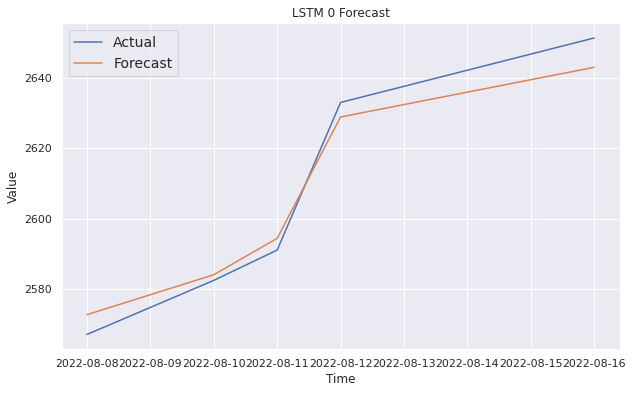

In [ ]:
reliance_stock_model.evaluate()

reliance_stock_model.show_result(0,5)

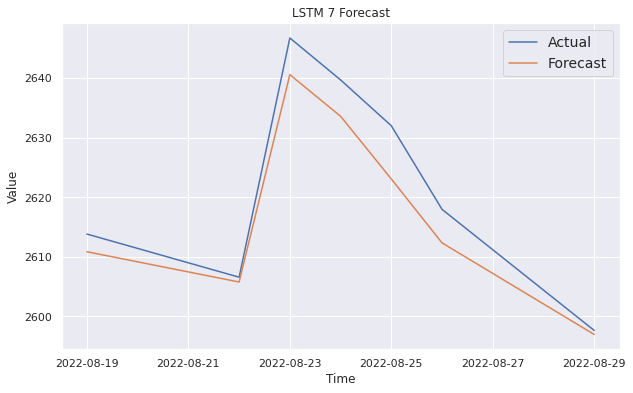

In [ ]:
reliance_stock_model.show_result(7,7)

In [ ]:
reliance_stock_model.Stockdata.normalized_x_test[-30:].shape

(30, 1)

In [ ]:
reliance_stock_model.model.predict(reliance_stock_model.Stockdata.normalized_x_test[-2:][np.newaxis,:]).shape

1/1 [==============================] - 0s 15ms/step


(1, 2, 1)

In [ ]:
reliance_stock_model.Stockdata.rnn_unscaled_forecast.shape

(90,)

In [1]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False



NameError: ignored

In [17]:
ticker = "RELIANCE"
# download the data
data = yf.download(ticker + '.ns', group_by="ticker", start = '1990-01-01', end = '2022-12-01')
data['Date'] = data.index
data.reset_index(drop=True, inplace=True)
data.drop(['Open', 'High','Low','Adj Close','Volume'], axis = 1, inplace = True)

data['Date'] = pd.to_datetime(data['Date'])
date_time = data.pop('Date')

# Save target series
series = data['Close']
  
# Create train data set
n = len(data)
train_df = data[0:int(n*0.85)]
val_df = data[int(n*0.85):int(n*0.9)]
test_df = data[int(n*0.9):]

[*********************100%***********************]  1 of 1 completed


In [19]:
from sklearn.preprocessing import StandardScaler

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
              #  train_df, val_df, test_df,
               label_columns=['Close']):

    train_mean = train_df.mean()
    train_std = train_df.std()

    scaler = StandardScaler()
    
    self.train_df['Close'] = scaler.fit_transform(train_df['Close'])  # - train_mean) / train_std
    self.val_df['Close'] = scaler.transform(val_df['Close']) 
    self.test_df['Close'] = scaler.transform(test_df['Close'])
    self.scaler = scaler 




    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(self.train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  def plot(self, model=None, plot_col='Close', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')



In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

[*********************100%***********************]  1 of 1 completed


Total window size: 37
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36]
Label column name(s): ['Close']

In [5]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=10):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  optimizer = keras.optimizers.Nadam(lr=1e-3)

        # compile model
  model.compile(loss=keras.losses.Huber(),
                      optimizer=optimizer,
                      metrics=["mae"])
  # model.compile(loss=tf.keras.losses.MeanSquaredError(),
  #               optimizer=tf.keras.optimizers.Adam(),
  #               metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [6]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=24)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

In [7]:
OUT_STEPS = 7
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window
multi_val_performance = {}
multi_performance = {}

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(100, return_sequences=False),

    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*1,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

[*********************100%***********************]  1 of 1 completed
          Open      High       Low     Close  Adj Close    Volume
5752  3.015234  2.983078  2.872298  2.842665   2.964151 -0.369511
5753  2.802098  2.798750  2.820624  2.813041   2.933944 -0.419932
5754  2.884560  2.840141  2.774418  2.779691   2.899936 -0.359983
5755  2.739740  2.710265  2.717841  2.723984   2.843131 -0.351405
5756  2.728199  2.770420  2.738963  2.776524   2.896706 -0.446995
...        ...       ...       ...       ...        ...       ...
6086  3.833152  3.862776  3.870520  3.886764   4.057073 -0.381957
6087  3.916172  3.862408  3.817337  3.875026   4.045039 -0.429036
6088  3.916917  3.877677  3.810171  3.768641   3.935957 -0.354283
6089  3.610896  3.620868  3.565377  3.619032   3.782556 -0.325612
6090  3.499395  3.447394  3.014309  3.034568   3.183277  0.158679

[339 rows x 6 columns]


<MapDataset element_spec=(TensorSpec(shape=(None, 30, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7, 1), dtype=tf.float32, name=None))>

In [23]:
column_indices = {name: i for i, name in enumerate(single_step_window.train_df.columns)}

column_indices['Close']

3

[*********************100%***********************]  1 of 1 completed


(None, 200, 1)
(None, 3, 1)
5/5 [==============================] - 0s 3ms/step - loss: 0.0145 - mean_absolute_error: 0.0892
(32, 200, 1)
(32, 3, 1)
(32, 200, 1)
(32, 3, 1)
(32, 200, 1)
(32, 3, 1)


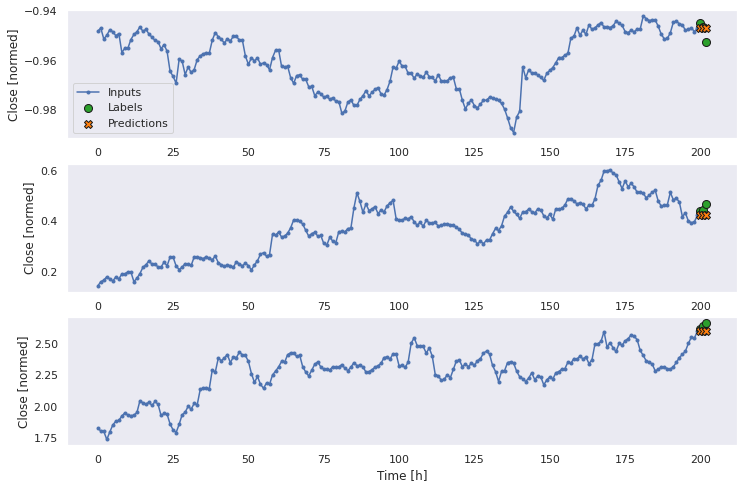

In [12]:

class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    print(inputs.shape)
    print(tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1]).shape)
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])


multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

5/5 [==============================] - 0s 12ms/step - loss: 0.1932 - mae: 0.5367


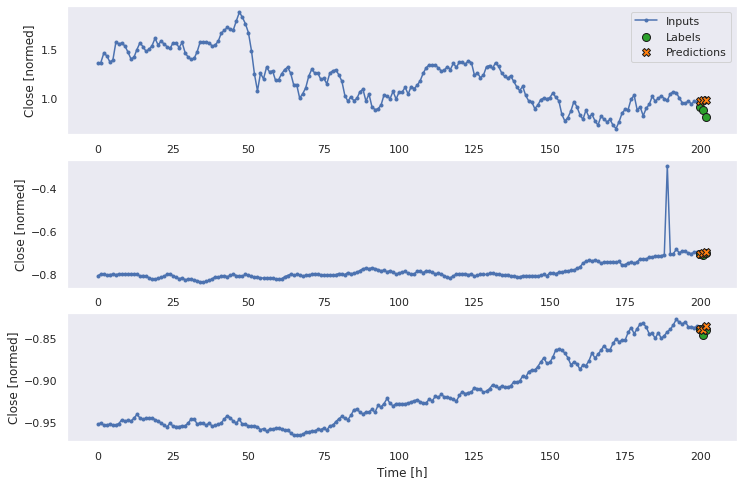

(20,)
(20,)


,Date,Actual,Forecast
0,2022-12-20,NaN,2603.447754
1,2022-12-21,NaN,2605.114990
2,2022-12-22,NaN,2602.030762
3,2022-12-23,NaN,2612.487061
4,2022-12-24,NaN,2599.490967
5,2022-12-25,NaN,2613.791748
6,2022-12-26,NaN,2592.664062


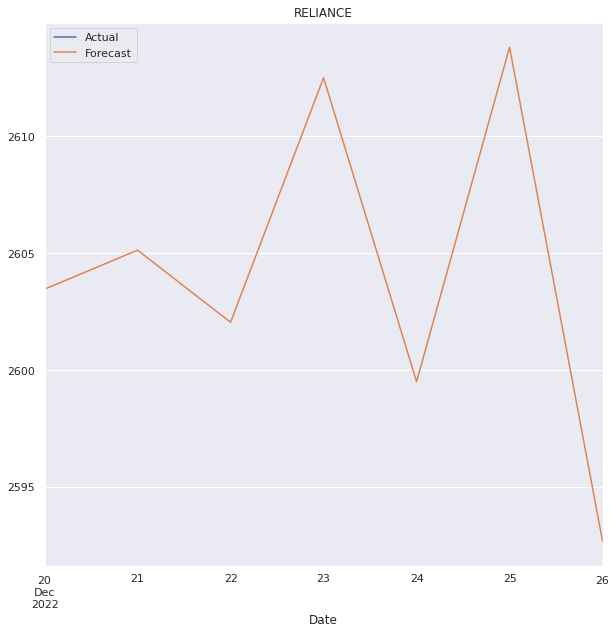

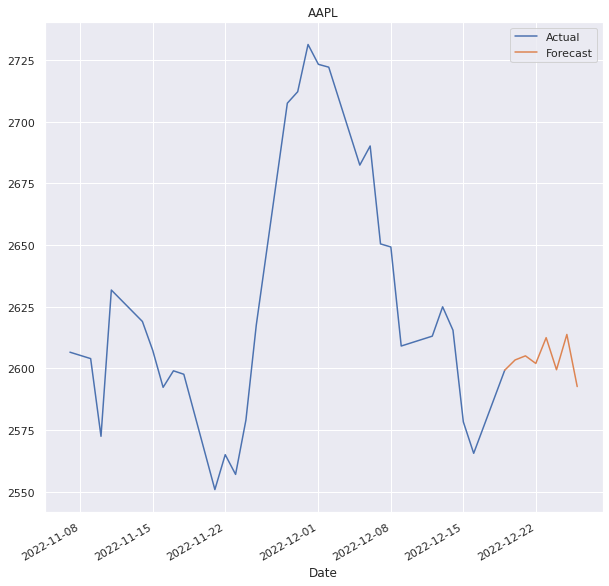

## New model CNN + LSTM

In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.4 MB/s 
     |████████████████████████████████| 62 kB 1.9 MB/s 
     |████████████████████████████████| 128 kB 25.2 MB/s 
     |████████████████████████████████| 112 kB 78.8 MB/s 
     |████████████████████████████████| 110 kB 76.7 MB/s 
     |████████████████████████████████| 4.0 MB 61.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import yfinance as yf
import random
from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

keras.backend.clear_session()


In [32]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [25]:
window_size = 4
batch_size = 3
shuffle_buffer_size = 10
split_time = 30


In [37]:
series = np.array(list(range(100)))
time = np.array(list(range(100)))

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

data = windowed_dataset(x_train,window_size, batch_size,shuffle_buffer_size)

In [38]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
model = keras.models.Sequential()
model.add(keras.layers.Conv1D(filters = 32, kernel_size = 5, strides=1, padding='causal',
activation='relu', input_shape = [None,1]))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(32,return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(32,return_sequences=True)))
model.add(keras.layers.Dense(1))

model.compile(loss = 'mse', optimizer = keras.optimizers.SGD(lr = 1e-6, momentum=0.9))
history = model.fit(data, epochs = 100)

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


9/9 [==============================] - 5s 10ms/step - loss: 332.6494
Epoch 2/100
9/9 [==============================] - 0s 8ms/step - loss: 332.2349
Epoch 3/100
9/9 [==============================] - 0s 8ms/step - loss: 331.5485
Epoch 4/100
9/9 [==============================] - 0s 9ms/step - loss: 330.9238
Epoch 5/100
9/9 [==============================] - 0s 9ms/step - loss: 330.0410
Epoch 6/100
9/9 [==============================] - 0s 9ms/step - loss: 329.2673
Epoch 7/100
9/9 [==============================] - 0s 8ms/step - loss: 328.4907
Epoch 8/100
9/9 [==============================] - 0s 8ms/step - loss: 327.6834
Epoch 9/100
9/9 [==============================] - 0s 8ms/step - loss: 326.8361
Epoch 10/100
9/9 [==============================] - 0s 9ms/step - loss: 325.9523
Epoch 11/100
9/9 [==============================] - 0s 8ms/step - loss: 325.1022
Epoch 12/100
9/9 [==============================] - 0s 9ms/step - loss: 324.3807
Epoch 13/100
9/9 [==============================

In [39]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

1/1 [==============================] - 0s 18ms/step


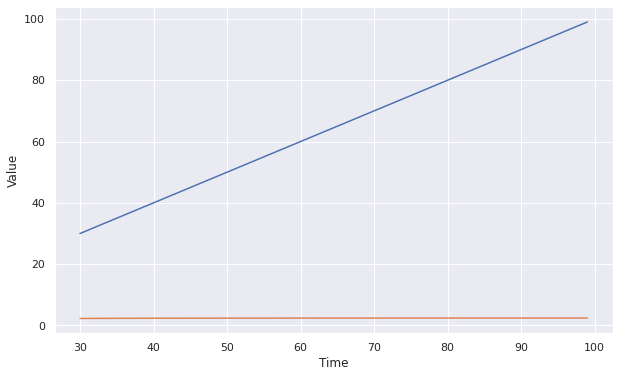

In [40]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)